# Import functions/Define Constants #

In [1]:
from Collision3D_pythonOptimized import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

# Define useful constants
amu = 1.67e-27 ; eps0 = 8.854e-12 ; qe = 1.6e-19 # SI units 

# Define physical params
m = 40. *amu; q = 1. *qe; wr = 2*np.pi*5e6; wz = 2*np.pi*.5e6 # SI units

# Define sim params
Nr = 501 ; Nz = 201 # number of cells related to trapping axis needs to be odd to allow null line
Nrmid = (Nr-1)/2 ; Nzmid = (Nz-1)/2 # middle cell which exists at r=0 (z=0) in physical units
Dr = Nr*1.5e-9 ; Dz = Nz*4.5e-7 # physical width in m of the sim
dr = Dr/float(Nr) ; dz = Dz/float(Nz) # width of a cell in z in m
Ezf = np.zeros((Nr,Nr, Nz)) ; Erf = np.zeros((Nr,Nr, Nz)) # array of electric fields s

# Here we describe how the collisional particles work
# they are a list of lists where the first index is the particle identifier
# the second index gives r,z,vr,vz,q,m,a (dipole moment)
aH2 = 8e-31 # dipole moment of H2 in SI units
mH2 = 2.0*amu # mass of H2 in kg

Nt = 300000# number of time steps to take
dtSmall = 1e-12 ;dtCollision = 1e-16; dtLarge = 1e-10 # length of a time step in s
Dt = dtSmall*Nt

first = 10 ; last=Nt

# Generates the forces generated by the RF and DC Field in the x,y and z directions
Using our axial and radial trapping frequencies we calculate the force that the potential exerts in every cell using,
$F = \frac{m\omega^2_x}{q}\Delta x$, where x is the respective coordinate.

In [2]:
# Here we'll make the DC and RF (pseudo)potentials
RFx,RFy = makeRF0(m,q,wr,Nr,Nz,Nrmid,Nzmid,dr)
DC = makeDC(m,q,wz,Nz,Nr,Nzmid,dz)
#DC = DC/90
#Vfield = makeVField(m,q,wr,wz,Nr,Nz,Nrmid,Nzmid,dr,dz) # we add a matrix of the potential energy through our trap
nullFields = np.zeros((Nr,Nr,Nz))
print("constants set and modules imported") ; print("Simulation Size = ",Dr,"m in r ", Dz,"m in z")

constants set and modules imported
Simulation Size =  7.515e-07 m in r  9.044999999999999e-05 m in z


# Define random selection of parameters

In [3]:
def Boltz(m,T,vmin=0,vmax=5000,bins=100):
    amu = 1.66*10**-27
    m = m*amu
    k = 1.386e-23 # boltzmann constant
    boltz = np.zeros(bins) # initialize vector
    dv = (vmax - vmin)/bins # define bin spacing in speed
    a = (k*T/m)**(1/2) # normalization constant for distribution function

    
    for i in range(bins):
        vhere = vmin + i*dv # define speed of bin
        vlast = vhere-dv
        boltz[i] = (special.erf(vhere/(a*np.sqrt(2))) - np.sqrt(2/np.pi)*(vhere/a)*np.exp(-vhere**2/(2*a**2)) ) - (special.erf(vlast/(a*np.sqrt(2))) - np.sqrt(2/np.pi)*(vlast/a)*np.exp(-vlast**2/(2*a**2)) ) # here we use the cumulative distribution function and subtract the one-step down value from the this step value for the probability density in this slice
    
    return boltz/np.sum(boltz)

In [7]:
# We set all our initial values for the simulation
Ni=2
Nc=1
vf = makeVf(Ni,1.0*q,m,wz)

T = 300
collisionalMass = 2
vMin = 50
vMax = 5000
numBins = 1000
boltzDist = Boltz(collisionalMass,T,vMin,vMax,numBins)
v = np.linspace(vMin,vMax,numBins)
angles = np.linspace(-np.pi/2,np.pi/2,100)
offsets = np.linspace(-2e-9,2e-9,200)
max_hypotenuse = 1.5e-7

velocity = random.choices(v,weights=boltzDist)[0]
angle_choiceXY = random.choice(angles); angle_choiceZ = random.choice(angles)
offset_choice = random.choice(offsets)
ion_collided = random.randint(0,Ni-1)

v = velocity
x = -np.cos(angle_choiceZ)*max_hypotenuse 
y = np.sin(angle_choiceXY)*x; x = np.cos(angle_choiceXY)*x
vx = np.abs(velocity*np.cos(angle_choiceZ))
vy = np.sin(angle_choiceXY)*vx; vx = np.cos(angle_choiceXY)*vx
z = vf[ion_collided,2] + np.sin(angle_choiceZ)*max_hypotenuse + offset_choice
vz=-1*velocity*np.sin(angle_choiceZ)

collision=True


# Runs the Simulation
Run the simulation using our monte carlo parameters in 3D

The monte carlo parametrs chosen were: 
velocity: 1675.2252252252251 m/s 
angle in XY plane: -1.3803967720318788 rad 
angle in Z plane: 1.5073298085405575 rad 
offset: 1.6381909547738694e-09 m 
ion collided: 1


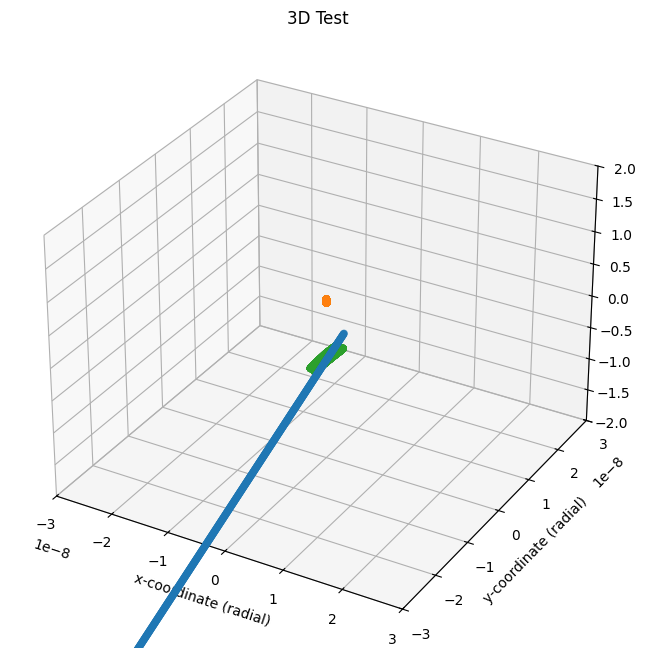

In [8]:
print(f"The monte carlo parametrs chosen were: \nvelocity: {v} m/s \nangle in XY plane: {angle_choiceXY} rad \nangle in Z plane: {angle_choiceZ} rad \noffset: {offset_choice} m \nion collided: {ion_collided}")

xs,ys,zs,vxs,vys,vzs,xcolls,ycolls,zcolls,vxcolls,vycolls,vzcolls,reorder = runFasterCollision(vf,x,y,z,vx,vy,vz,q,mH2,aH2,Nt,dtSmall,dtCollision,RFx,RFy,DC,Nr,Nz,dr,dz,dtLarge, withCollision=collision)    

pointSkip = 10
xlimit = 3e-8; ylimit = 3e-8; zlimit = 2e-5
first = 10; last = 10000; title = "3D Test"

plotSim(Nc,Ni,xcolls[:pointSkip],ycolls[:pointSkip],zcolls[:pointSkip],xs[:pointSkip],ys[:pointSkip],zs[:pointSkip],xlimit,ylimit,zlimit,first,last,title)

In [6]:
#plotSim(Nc,Ni,xcolls,ycolls,zcolls,xs,ys,zs,3e-8,3e-8,10,500,"3D Test")